In [21]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install category_encoders


In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.combine import SMOTEENN

df_customer=pd.read_csv('customer_dataset.csv')
df_transactions=pd.read_csv('updated_fraud_transactions.csv')

df_transactions.dtypes


,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64


In [21]:
df = df_transactions.merge(df_customer[['Customer ID', 'Device Count','Location','Account Type','Age']], left_on='Sender Account ID', right_on='Customer ID')
df.dtypes

,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64
Customer ID,int64
Device Count,int64


In [22]:
#Encoding

df = pd.get_dummies(df, columns=['IN_OUT', 'Account Type', 'Transaction Type'], drop_first=True)
bool_columns = df.select_dtypes(include='bool').columns

df[bool_columns] = df[bool_columns].astype(int)

label_encoder = LabelEncoder()

df['Recipient Bank'] = label_encoder.fit_transform(df['Recipient Bank'])

district_map = {
    'Colombo': 1,       # Western Province
    'Gampaha': 2,       # Western Province
    'Kalutara': 3,      # Western Province
    'Kandy': 4,         # Central Province
    'Matale': 5,        # Central Province
    'Nuwara Eliya': 6,  # Central Province
    'Galle': 7,         # Southern Province
    'Matara': 8,        # Southern Province
    'Hambantota': 9,    # Southern Province
    'Jaffna': 10,       # Northern Province
    'Kilinochchi': 11,  # Northern Province
    'Mannar': 12,       # Northern Province
    'Vavuniya': 13,     # Northern Province
    'Mullaitivu': 14,   # Northern Province
    'Trincomalee': 15,  # Eastern Province
    'Batticaloa': 16,   # Eastern Province
    'Ampara': 17,       # Eastern Province
    'Kurunegala': 18,   # North Western Province
    'Puttalam': 19,     # North Western Province
    'Anuradhapura': 20, # North Central Province
    'Polonnaruwa': 21,  # North Central Province
    'Badulla': 22,      # Uva Province
    'Monaragala': 23,   # Uva Province
    'Ratnapura': 24,    # Sabaragamuwa Province
    'Kegalle': 25       # Sabaragamuwa Province
}

# Step 2: Apply the district map to the 'Location' column in your dataframe df
df['Location'] = df['Location'].map(district_map)

In [23]:

# Column Scaling
# Min-Max scaling for Age
df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
cols_to_standardize = ['Amount']
scaler = StandardScaler()
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])



In [24]:
#Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour

df['day_of_week'] = df['Timestamp'].dt.day_name()
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['Odd_Hour_Transaction'] = df['Hour'].apply(lambda x: 1 if x in [0, 1, 2, 3, 4, 5,6] else 0)


monthly_customer_features = df.groupby(['Customer ID', 'Year', 'Month']).agg(
    Monthly_Transaction_Count=('Transaction ID', 'count'),
    Monthly_Average_Transaction_Amount=('Amount', 'mean')
).reset_index()

# Merge the new monthly features back into the original DataFrame
df = df.merge(monthly_customer_features, on=['Customer ID', 'Year', 'Month'], how='left')

# Transaction Amount Ratio
df['Transaction Amount Ratio'] = df['Amount'] / df['Monthly_Average_Transaction_Amount']


#Transaction Type Based Features
#transaction_type_count = df.groupby('Customer ID')['Transaction Type'].nunique().reset_index()
#transaction_type_count.columns = ['Customer ID', 'Transaction Type Count']
# Merge the counts back into the original DataFrame
#df = df.merge(transaction_type_count, on='Customer ID', how='left')
# Calculate the proportion of each transaction type relative to the total transactions for each customer
#df['Transaction Type Proportion'] = df.groupby(['Customer ID', 'Transaction Type'])['Transaction Type'].transform('count') / df['Transaction_Count']


#Device Count Levels
bins = [0, 3, 7, 11]
labels = [1, 2, 3]  # Low: 1, Medium: 2, High: 3
df['Device Count Category'] = pd.cut(df['Device Count'], bins=bins, labels=labels, right=True)
df['Device Count Category'] = df['Device Count Category'].astype(int)
df.head()


,Transaction ID,Timestamp,Sender Account ID,Amount,Recipient Bank,Fraud,Customer ID,Device Count,Location,Age,...,Month,Day,Hour,day_of_week,weekend,Odd_Hour_Transaction,Monthly_Transaction_Count,Monthly_Average_Transaction_Amount,Transaction Amount Ratio,Device Count Category
0,T00001,2023-08-14 08:37:07,10095,1.105813,4,0,10095,10,16,0.661290,...,8,14,8,Monday,0,0,79,-0.224165,-4.933040,3
1,T00002,2023-12-04 12:54:11,10098,-0.120951,1,0,10098,10,8,0.677419,...,12,4,12,Monday,0,0,81,0.137635,-0.878785,3
2,T00003,2023-07-09 23:16:11,10097,1.030623,8,0,10097,8,10,0.741935,...,7,9,23,Sunday,1,0,89,-0.050652,-20.346942,3
3,T00004,2023-06-26 07:04:39,10039,-0.524232,5,0,10039,1,4,0.677419,...,6,26,7,Monday,0,0,80,0.058702,-8.930337,1
4,T00005,2023-09-28 02:40:56,10018,0.662351,4,0,10018,4,24,0.290323,...,9,28,2,Thursday,0,1,83,0.009588,69.084147,2


In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [26]:
df.drop(columns=['Transaction ID', 'Timestamp','Sender Account ID','Device Count','day_of_week','Year','Customer ID'], inplace=True)






In [8]:
df.head()

,Amount,Recipient Bank,Fraud,Location,Age,IN_OUT_Out,Account Type_Fixed Deposit,Account Type_Savings,Transaction Type_Debit,Transaction Type_Payment,Transaction Type_Transfer,Month,Day,Hour,weekend,Odd_Hour_Transaction,Monthly_Transaction_Count,Monthly_Average_Transaction_Amount,Transaction Amount Ratio,Device Count Category
0,1.105813,4,0,16,0.661290,0,0,1,0,0,1,8,14,8,0,0,79,-0.224165,-4.933040,3
1,-0.120951,1,0,8,0.677419,0,0,1,0,0,1,12,4,12,0,0,81,0.137635,-0.878785,3
2,1.030623,8,0,10,0.741935,0,0,0,0,0,0,7,9,23,1,0,89,-0.050652,-20.346942,3
3,-0.524232,5,0,4,0.677419,0,0,0,0,0,0,6,26,7,0,0,80,0.058702,-8.930337,1
4,0.662351,4,0,24,0.290323,1,0,1,1,0,0,9,28,2,0,1,83,0.009588,69.084147,2


In [30]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Amount                              100000 non-null  float64
 1   Recipient Bank                      100000 non-null  int64  
 2   Fraud                               100000 non-null  int64  
 3   Location                            100000 non-null  int64  
 4   Age                                 100000 non-null  float64
 5   IN_OUT_Out                          100000 non-null  int64  
 6   Account Type_Fixed Deposit          100000 non-null  int64  
 7   Account Type_Savings                100000 non-null  int64  
 8   Transaction Type_Debit              100000 non-null  int64  
 9   Transaction Type_Payment            100000 non-null  int64  
 10  Transaction Type_Transfer           100000 non-null  int64  
 11  Month                      

In [27]:
#Data Balancing
df= df.dropna(subset=['Fraud'])
X = df.drop(columns=['Fraud'])
y = df['Fraud']

smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X, y)

print(f"Number of Fraudulent Transactions: {sum(y_smoteenn == 0)}")
print(f"Number of Non-Fraudulent Transactions: {sum(y_smoteenn == 1)}")

Number of Fraudulent Transactions: 74731
Number of Non-Fraudulent Transactions: 75217


Feature Selection using FDE (Feature Discriminability Evaluation)

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42, stratify=y_smoteenn)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

In [58]:
# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [59]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display the scores
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Rank features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)

Feature Importances:
                               Feature  Importance
0                               Amount    0.176869
16  Monthly_Average_Transaction_Amount    0.140581
12                                Hour    0.094016
1                       Recipient Bank    0.069530
17            Transaction Amount Ratio    0.067007
7               Transaction Type_Debit    0.061202
3                                  Age    0.060110
8             Transaction Type_Payment    0.059981
2                             Location    0.051641
15           Monthly_Transaction_Count    0.036547
11                                 Day    0.030664
18               Device Count Category    0.028048
10                               Month    0.026333
4                           IN_OUT_Out    0.021573
9            Transaction Type_Transfer    0.019050
14                Odd_Hour_Transaction    0.018816
5           Account Type_Fixed Deposit    0.015066
6                 Account Type_Savings    0.013555
13        

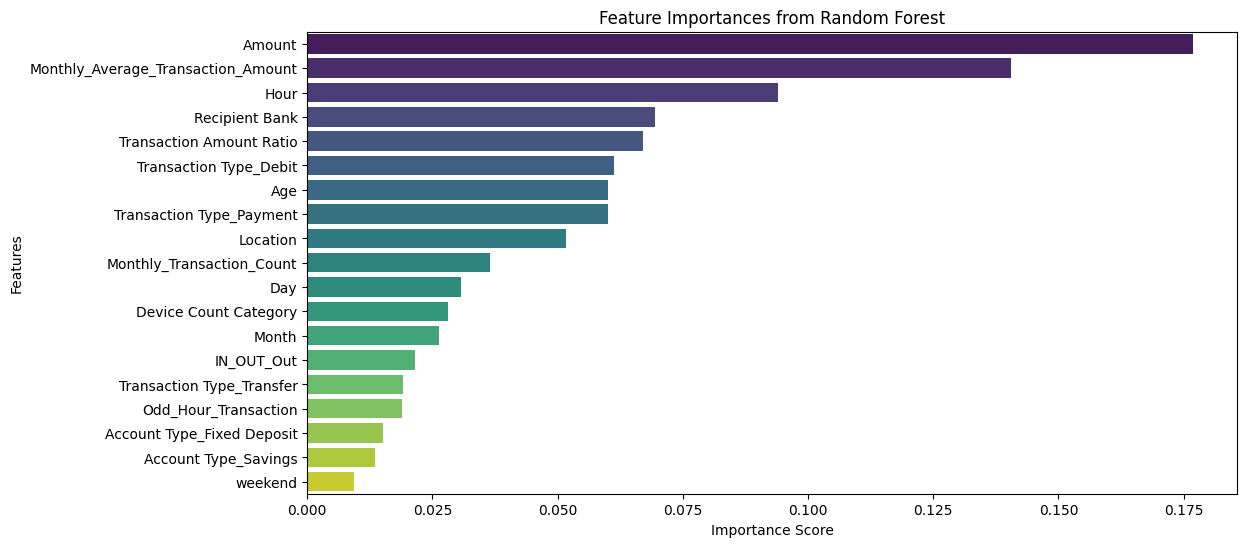

In [60]:
# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

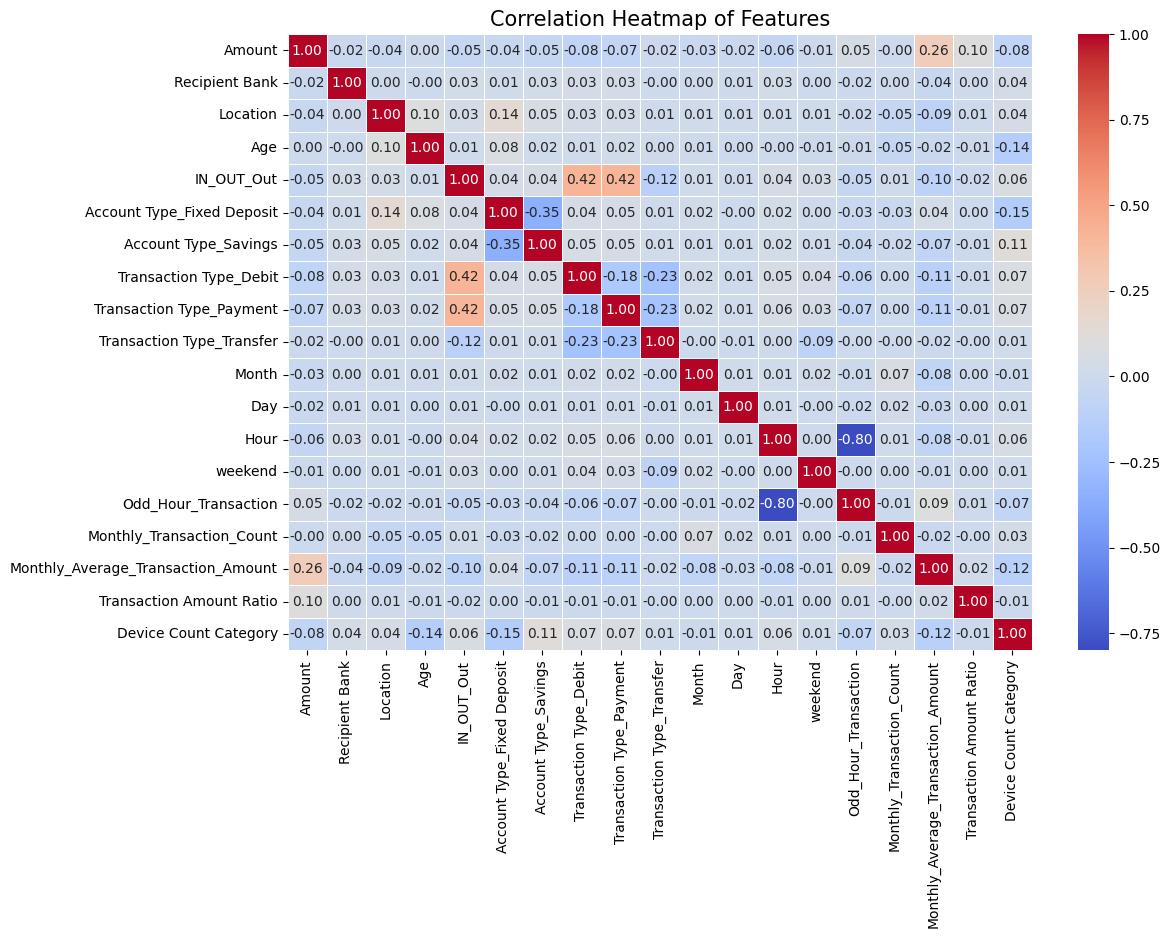

In [61]:
correlation_matrix = X_train.corr()


plt.figure(figsize=(12, 8))

# Draw the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add title to the heatmap
plt.title("Correlation Heatmap of Features", fontsize=15)

# Show the heatmap
plt.show()

In [64]:
rf2 = RandomForestClassifier(random_state=42)

#Cross Validation
k = 5  # Number of folds
cv_scores = cross_val_score(rf2, X_train, y_train, cv=k, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")


rf2.fit(X_train, y_train)

y_pred = rf2.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Cross-Validation F1 Scores: [0.9655761  0.96357238 0.96401578 0.96656391 0.96424846]
Mean F1 Score: 0.9647953261594256
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14946
           1       0.97      0.97      0.97     15044

    accuracy                           0.97     29990
   macro avg       0.97      0.97      0.97     29990
weighted avg       0.97      0.97      0.97     29990



After Feature Selection

In [65]:
# Select the top 10 most important features
top_features = feature_importances_df.nlargest(10, 'Importance')['Feature']

#Trainingset with only top 10 features
X_train_top = X_train[top_features]


print("Top 10 Features:")
print(top_features)

Top 10 Features:
0                                 Amount
16    Monthly_Average_Transaction_Amount
12                                  Hour
1                         Recipient Bank
17              Transaction Amount Ratio
7                 Transaction Type_Debit
3                                    Age
8               Transaction Type_Payment
2                               Location
15             Monthly_Transaction_Count
Name: Feature, dtype: object


With Hyperparameter Tuning

In [73]:


#Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, scale_pos_weight=13, max_depth=15,
                             learning_rate=0.05, n_estimators=3000, reg_lambda=3,
                             reg_alpha=3, random_state=42, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
}

# Train and evaluate models
for model_name, model in models.items():
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"{model_name} Cross-Validation F1 Scores: {cv_scores}")
    print(f"{model_name} Mean F1 Score: {cv_scores.mean()}\n")

    # Fit the model on the full training set
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    print(f"{model_name} Classification Report on Validation Set:")
    print(classification_report(y_val, y_val_pred))

    # Confusion matrix for the validation set
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    print(f"{model_name} Confusion Matrix on Validation Set:")
    print(conf_matrix_val)

    # Calculate ROC-AUC for the validation set
    y_val_proba = model.predict_proba(X_val)[:, 1]
    roc_auc_val = roc_auc_score(y_val, y_val_proba)
    print(f"{model_name} ROC-AUC Score on Validation Set: {roc_auc_val:.4f}")

    # Test Set Predictions
    y_test_pred = model.predict(X_test)
    print(f"{model_name} Classification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix for the test set
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    print(f"{model_name} Confusion Matrix on Test Set:")
    print(conf_matrix_test)

    # Calculate ROC-AUC for the test set
    y_test_proba = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    print(f"{model_name} ROC-AUC Score on Test Set: {roc_auc_test:.4f}")

    print("\n" + "="*60 + "\n")


Random Forest Cross-Validation F1 Scores: [0.9655761  0.96357238 0.96401578 0.96656391 0.96424846]
Random Forest Mean F1 Score: 0.9647953261594256

Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7473
           1       0.97      0.97      0.97      7522

    accuracy                           0.97     14995
   macro avg       0.97      0.97      0.97     14995
weighted avg       0.97      0.97      0.97     14995

Random Forest Confusion Matrix on Validation Set:
[[7259  214]
 [ 211 7311]]
Random Forest ROC-AUC Score on Validation Set: 0.9958
Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14946
           1       0.97      0.97      0.97     15044

    accuracy                           0.97     29990
   macro avg       0.97      0.97      0.97     29990
weighted avg      

CNN MODEL

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input data to be 3D for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()

#Conv layer 1
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

#Conv layer 2
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

#Conv Layer 3
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())



model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Model evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.8331 - loss: 0.7648 - val_accuracy: 0.8834 - val_loss: 0.2907
Epoch 2/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.8819 - loss: 0.2938 - val_accuracy: 0.8972 - val_loss: 0.2595
Epoch 3/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.8966 - loss: 0.2636 - val_accuracy: 0.9039 - val_loss: 0.2466
Epoch 4/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.9004 - loss: 0.2548 - val_accuracy: 0.9034 - val_loss: 0.2396
Epoch 5/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.9109 - loss: 0.2313 - val_accuracy: 0.9164 - val_loss: 0.2177
Epoch 6/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.9159 - loss: 0.2199 - val_accuracy: 0.9155 - val_loss: 0.2207
Epoch 7/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9199 - loss: 0.2143 - val_accuracy: 0.9179 - val_loss: 0.2179
Epoch 8/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.9207 -

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Confusion Matrix:
[[13934  1012]
 [  827 14217]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     14946
           1       0.93      0.95      0.94     15044

    accuracy                           0.94     29990
   macro avg       0.94      0.94      0.94     29990
weighted avg       0.94      0.94      0.94     29990



In [ ]:
X_val = scaler.transform(X_val)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)



In [19]:

y_pred_val = (model.predict(X_val) > 0.5).astype("int32")
# Confusion Matrix on Validation Set
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report pn Validation Set
class_report = classification_report(y_val, y_pred_val)
print("Classification Report:")
print(class_report)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:
[[6988  485]
 [ 398 7124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7473
           1       0.94      0.95      0.94      7522

    accuracy                           0.94     14995
   macro avg       0.94      0.94      0.94     14995
weighted avg       0.94      0.94      0.94     14995



In [ ]:
for pred, actual in zip(y_pred, y_test):
    print(f"Predicted: {pred}, Actual: {actual}")

Streaming output truncated to the last 5000 lines.
Predicted: [1], Actual: 1
Predicted: [1], Actual: 1
Predicted: [1], Actual: 1
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [1], Actual: 1
Predicted: [0], Actual: 0
Predicted: [1], Actual: 1
Predicted: [1], Actual: 1
Predicted: [1], Actual: 1
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [1], Actual: 1
Predicted: [1], Actual: 1
Predicted: [0], Actual: 0
Predicted: [1], Actual: 0
Predicted: [1], Actual: 1
Predicted: [1], Actual: 1
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [1], Actual: 1
Predicted: [1], Actual: 0
Predicted: [0], Actual: 0
Predicted: [1], Actual: 1
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [0], Actual: 0
Predicted: [1], Actual: 1
Predicted: [0

LSTM

In [ ]:
import torch
import torch.nn as nn



In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Assuming y_train is a Series
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
X_train_lstm = X_train_tensor.view(X_train_tensor.size(0), 1, X_train_tensor.size(1))
X_test_lstm = X_test_tensor.view(X_test_tensor.size(0), 1, X_test_tensor.size(1))

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)  # 64 hidden units
        self.fc = nn.Linear(64, 1)  # Output layer for binary classification

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Take the last hidden state
        return torch.sigmoid(out)  # Output probabilities

In [ ]:
model = LSTMModel(input_size=X_train_tensor.size(1))  # Input size matches the number of features
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
model.train()
num_epochs = 30

for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train_lstm)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

In [86]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_lstm)
    y_pred_class = (y_pred_prob > 0.5).float()

    y_pred_class_np = y_pred_class.numpy()
    y_test_np = y_test_tensor.numpy()


    conf_matrix = confusion_matrix(y_test_np, y_pred_class_np)
    class_report = classification_report(y_test_np, y_pred_class_np)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

Confusion Matrix:
[[11343  3603]
 [ 3165 11879]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77     14946
         1.0       0.77      0.79      0.78     15044

    accuracy                           0.77     29990
   macro avg       0.77      0.77      0.77     29990
weighted avg       0.77      0.77      0.77     29990



Model Aggregation

In [87]:
!pip install tensorflow


In [28]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

In [29]:
# Step 1: Split into training and testing sets (80% train, 20% test)
X_train_temp, X_test_ens, y_train_temp, y_test_ens = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)

# Step 2: Split the training set into training and validation sets (70% train, 10% val)
X_train_ens, X_val_ens, y_train_ens, y_val_ens = train_test_split(X_train_temp, y_train_temp, test_size=0.125, random_state=42)

In [30]:
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_ens)
X_test_cnn = scaler.transform(X_test_ens)
X_val_cnn= scaler.transform(X_val_ens)



X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)
X_val_cnn= X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], 1)


In [31]:

# CNN model
cnn_model = Sequential()

# Conv1D layers
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the CNN
cnn_model.fit(X_train_cnn, y_train_ens, epochs=20, batch_size=64, validation_data=(X_test_cnn, y_test_ens), callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.8308 - loss: 0.3802 - val_accuracy: 0.8797 - val_loss: 0.2699
Epoch 2/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8788 - loss: 0.2753 - val_accuracy: 0.8894 - val_loss: 0.2569
Epoch 3/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8939 - loss: 0.2457 - val_accuracy: 0.9052 - val_loss: 0.2239
Epoch 4/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.9030 - loss: 0.2272 - val_accuracy: 0.9099 - val_loss: 0.2099
Epoch 5/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9123 - loss: 0.2086 - val_accuracy: 0.9121 - val_loss: 0.2067
Epoch 6/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - accuracy: 0.9148 - loss: 0.2031 - val_accuracy: 0.9142 - val_loss: 0.2003
Epoch 7/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9153 - loss: 0.1966 - val_accuracy: 0.9139 - val_loss: 0.2032
Epoch 8/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.9202 -

In [32]:

# Get predicted probabilities for CNN
cnn_probs = cnn_model.predict(X_test_cnn)

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [33]:
logistic_regression = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.01,
    class_weight={0: 1, 1: 10},
    random_state=42,
    max_iter=1000
)
random_forest = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
xgboost = XGBClassifier(use_label_encoder=False, scale_pos_weight=13,max_depth=15,learning_rate=0.05,n_estimators=3000,reg_lambda=3, reg_alpha=3,
    random_state=42,
    eval_metric=['logloss', 'auc'])

adaboost = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.05,
        random_state=42
    )

# Fit traditional models
logistic_regression.fit(X_train_ens, y_train_ens)
random_forest.fit(X_train_ens, y_train_ens)
xgboost.fit(X_train_ens, y_train_ens)
adaboost.fit(X_train_ens, y_train_ens)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:50:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.05, n_estimators=100, random_state=42)

In [ ]:
y_pred_logistic = logistic_regression.predict(X_test_ens)
y_pred_rf = random_forest.predict(X_test_ens)
y_pred_xgb = xgboost.predict(X_test_ens)
y_pred_ada = adaboost.predict(X_test_ens)

In [ ]:
y_pred_probs_rf = random_forest.predict_proba(X_test_ens)[:, 1]
y_pred_probs_xgb = xgboost.predict_proba(X_test_ens)[:, 1]
y_pred_probs_ada = adaboost.predict_proba(X_test_ens)[:, 1]
y_pred_probs_logistic = logistic_regression.predict_proba(X_test_ens)[:, 1]

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred_logistic = logistic_regression.predict(X_test_ens)
y_pred_rf = random_forest.predict(X_test_ens)
y_pred_xgb = xgboost.predict(X_test_ens)
y_pred_ada = adaboost.predict(X_test_ens)

cnn_preds_binary = (cnn_probs > 0.5).astype(int).flatten()  # Ensure it is 1D

# Create a 2D array of predictions
predictions_majority = np.array([y_pred_logistic, y_pred_rf, y_pred_xgb, y_pred_ada, cnn_preds_binary])

# Majority Voting
y_pred_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_majority)


In [ ]:
# Soft Voting
predictions_soft = np.array([y_pred_probs_logistic, y_pred_probs_rf, y_pred_probs_xgb, y_pred_probs_ada, cnn_probs.flatten()])
y_pred_soft = (predictions_soft.mean(axis=0) > 0.5).astype(int)

In [38]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define your LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_ens.shape[1], 1)))  # Adjust input shape based on your data
lstm_model.add(Dense(1, activation='sigmoid'))  # For binary classification
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train your model (example)
lstm_model.fit(X_train_ens, y_train_ens, epochs=10, batch_size=32)  # Adjust epochs and batch_size as needed


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.7460 - loss: 0.4901
Epoch 2/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.8560 - loss: 0.3282
Epoch 3/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.8628 - loss: 0.3093
Epoch 4/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8773 - loss: 0.2817
Epoch 5/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.8855 - loss: 0.2625
Epoch 6/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.8912 - loss: 0.2457
Epoch 7/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.8985 - loss: 0.2363
Epoch 8/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9030 - loss: 0.2272
Epoch 9/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9066 - loss: 0.2187
Epoch 10/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9091 - loss: 0.2142


In [39]:
X_test_array = X_test_ens.to_numpy()

# Reshape the test data for LSTM
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

lstm_probs_test = lstm_model.predict(X_test_reshaped)
lstm_preds_binary = (lstm_probs_test > 0.5).astype(int).flatten()


print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, lstm_preds_binary))

print("\nClassification Report:")
print(classification_report(y_test_ens, lstm_preds_binary))

# Calculate ROC-AUC Score
roc_auc_lstm = roc_auc_score(y_test_ens, lstm_probs_test)  # Use probabilities for ROC-AUC
print(f"ROC-AUC Score: {roc_auc_lstm:.4f}")


938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Confusion Matrix:
[[13643  1194]
 [ 1627 13526]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     14837
           1       0.92      0.89      0.91     15153

    accuracy                           0.91     29990
   macro avg       0.91      0.91      0.91     29990
weighted avg       0.91      0.91      0.91     29990

ROC-AUC Score: 0.9701


In [40]:
print(f"logistic shape: {y_pred_probs_logistic.shape}")
print(f"rf shape: {y_pred_probs_rf.shape}")
print(f"xgb shape: {y_pred_probs_xgb.shape}")
print(f"ada shape: {y_pred_probs_ada.shape}")
print(f"cnn shape: {cnn_probs.flatten().shape}")
print(f"lstm shape: {lstm_probs_test.flatten().shape}")

logistic shape: (29990,)
rf shape: (29990,)
xgb shape: (29990,)
ada shape: (29990,)
cnn shape: (29990,)
lstm shape: (29990,)


In [41]:
# Soft Voting
predictions_soft = np.array([
    y_pred_probs_logistic,
    y_pred_probs_rf,
    y_pred_probs_xgb,
    y_pred_probs_ada,
    cnn_probs.flatten(),
    lstm_probs_test.flatten()
])
y_pred_soft = (predictions_soft.mean(axis=0) > 0.5).astype(int)

In [42]:
print("Logistic Predictions Shape:", y_pred_logistic.shape)
print("Random Forest Predictions Shape:", y_pred_rf.shape)
print("XGBoost Predictions Shape:", y_pred_xgb.shape)
print("AdaBoost Predictions Shape:", y_pred_ada.shape)
print("CNN Predictions Shape:", cnn_preds_binary.shape)
print("LSTM Predictions Shape:", lstm_preds_binary.shape)

Logistic Predictions Shape: (29990,)
Random Forest Predictions Shape: (29990,)
XGBoost Predictions Shape: (29990,)
AdaBoost Predictions Shape: (29990,)
CNN Predictions Shape: (29990,)
LSTM Predictions Shape: (29990,)


In [43]:
# Majority Voting
predictions_majority = np.array([
    y_pred_logistic,
    y_pred_rf,
    y_pred_xgb,
    y_pred_ada,
    cnn_preds_binary,
    lstm_preds_binary  # Include LSTM binary predictions
])
y_pred_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_majority)


In [44]:

print("Majority Voting Ensemble")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, y_pred_majority))
print("Classification Report:")
print(classification_report(y_test_ens, y_pred_majority))

print("\nSoft Voting Ensemble")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, y_pred_soft))
print("Classification Report:")
print(classification_report(y_test_ens, y_pred_soft))

print("Majority Voting ROC")
print( roc_auc_score(y_test_ens, y_pred_majority))
print("Soft Voting ROC")
print( roc_auc_score(y_test_ens, y_pred_soft))

Majority Voting Ensemble
Confusion Matrix:
[[13934   903]
 [ 1095 14058]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     14837
           1       0.94      0.93      0.93     15153

    accuracy                           0.93     29990
   macro avg       0.93      0.93      0.93     29990
weighted avg       0.93      0.93      0.93     29990


Soft Voting Ensemble
Confusion Matrix:
[[13795  1042]
 [  396 14757]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     14837
           1       0.93      0.97      0.95     15153

    accuracy                           0.95     29990
   macro avg       0.95      0.95      0.95     29990
weighted avg       0.95      0.95      0.95     29990

Majority Voting ROC
0.9334378608263783
Soft Voting ROC
0.9518183651243398


Bagging

In [134]:
from sklearn.ensemble import BaggingClassifier

In [132]:
logistic_regression = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

random_forest = RandomForestClassifier(random_state=42)

xgboost = XGBClassifier(use_label_encoder=False, scale_pos_weight=13, max_depth=15,
                         learning_rate=0.05, n_estimators=3000, reg_lambda=3,
                         reg_alpha=3, random_state=42, eval_metric='logloss')

adaboost = AdaBoostClassifier(random_state=42)

In [136]:
bagged_logistic_regression = BaggingClassifier(logistic_regression, n_estimators=10, random_state=42)

# Bagging with Random Forest (not usually necessary)
bagged_random_forest = BaggingClassifier(random_forest, n_estimators=10, random_state=42)

# Bagging with XGBoost
bagged_xgboost = BaggingClassifier(xgboost, n_estimators=10, random_state=42)

# Bagging with AdaBoost
bagged_adaboost = BaggingClassifier(adaboost, n_estimators=10, random_state=42)

# Fit bagged models
bagged_logistic_regression.fit(X_train_ens, y_train_ens)
bagged_random_forest.fit(X_train_ens, y_train_ens)
bagged_xgboost.fit(X_train_ens, y_train_ens)
bagged_adaboost.fit(X_train_ens, y_train_ens)

BaggingClassifier(estimator=AdaBoostClassifier(random_state=42),
                  random_state=42)

In [137]:
predictions_logistic = bagged_logistic_regression.predict(X_test_ens)
predictions_random_forest = bagged_random_forest.predict(X_test_ens)
predictions_xgboost = bagged_xgboost.predict(X_test_ens)
predictions_adaboost = bagged_adaboost.predict(X_test_ens)

In [138]:
# Logistic Regression Bagging Results
print("Logistic Regression Bagging:")
print(classification_report(y_test_ens, predictions_logistic))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, predictions_logistic))
print("\n")

# Random Forest Bagging Results
print("Random Forest Bagging:")
print(classification_report(y_test_ens, predictions_random_forest))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, predictions_random_forest))
print("\n")

# XGBoost Bagging Results
print("XGBoost Bagging:")
print(classification_report(y_test_ens, predictions_xgboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, predictions_xgboost))
print("\n")

# AdaBoost Bagging Results
print("AdaBoost Bagging:")
print(classification_report(y_test_ens, predictions_adaboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, predictions_adaboost))
print("\n")

Logistic Regression Bagging:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     14837
           1       0.81      0.82      0.81     15153

    accuracy                           0.81     29990
   macro avg       0.81      0.81      0.81     29990
weighted avg       0.81      0.81      0.81     29990

Confusion Matrix:
[[11960  2877]
 [ 2792 12361]]


Random Forest Bagging:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14837
           1       0.96      0.97      0.96     15153

    accuracy                           0.96     29990
   macro avg       0.96      0.96      0.96     29990
weighted avg       0.96      0.96      0.96     29990

Confusion Matrix:
[[14250   587]
 [  519 14634]]


XGBoost Bagging:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     14837
           1       0.96      0.99      0.98     15153

    accurac